# Алгоритми навчання з вчителем Ч.1
## Визначимо функції
### Функція показу гістаграм

In [439]:
import pandas as pd
import seaborn as sns

def show_hists(data: pd.DataFrame):
     sns.set_theme()
     melted = pd.concat([data, target], axis=1).melt()
     
     g = sns.FacetGrid(melted,
                       col='variable',
                       col_wrap=3,
                       sharex=False,
                       sharey=False)
     
     g.map(sns.histplot, 'value')
     
     g.set_titles(col_template='{col_name}')
     
     g.tight_layout()


### Функція показу графіку кореляцій за географічним розташуванням

In [440]:
def show_geo_corr(data: pd.DataFrame, target: pd.Series):
    fig, ax = plt.subplots(figsize=(6, 5))
    
    sns.scatterplot(
        data=data,
        x='Longitude',
        y='Latitude',
        size=target,
        hue=target,
        palette='viridis',
        alpha=0.5,
        ax=ax)
    
    plt.legend(
        title='MedHouseVal',
        bbox_to_anchor=(1.05, 0.95),
        loc='upper left')
    plt.title('Median house value depending of\n their spatial location')
    
    plt.show()

### Функція показу матриці кореляцій

In [441]:
def show_correlation_matrix(data: pd.DataFrame):
    corr_mtx = data.corr()
    
    mask_mtx = np.zeros_like(corr_mtx)
    np.fill_diagonal(mask_mtx, 1)
    
    fig, ax = plt.subplots(figsize=(7, 6))
    
    sns.heatmap(data.corr(),
                cmap='coolwarm',
                center=0,
                annot=True,
                fmt='.2f',
                linewidth=0.5,
                square=True,
                mask=mask_mtx,
                ax=ax)

### Функція показу графіку викидів за ознакою

In [442]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore

def show_outliers(values, z_thresh=3.0):
    """
    values: pd.Series | np.ndarray | list
    Показує Z-оцінки, вихідні значення та підсвічує викиди за порогом |Z| > z_thresh.
    """
    # Перетворюємо на 1D масив числових значень
    if isinstance(values, pd.Series):
        data = values.to_numpy()
        index = values.index.to_numpy()
    elif isinstance(values, pd.DataFrame):
        data = values.iloc[:, 0].to_numpy()
        index = values.index.to_numpy()
    else:
        data = np.asarray(values)
        index = np.arange(len(data))

    data = data.astype(float)

    # Обчислюємо Z-оцінки, ігноруючи NaN
    data_z = zscore(data, nan_policy='omit')

    # Маска викидів
    outlier_mask = np.abs(data_z) > z_thresh

    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 7))

    # Графік Z-оцінок
    axes[0].plot(index, data_z, color='tab:red', label='Z-score')
    axes[0].axhline(0.0, color='gray', lw=1, ls='--')
    axes[0].axhline(z_thresh, color='orange', lw=1, ls='--', label=f'+{z_thresh}')
    axes[0].axhline(-z_thresh, color='orange', lw=1, ls='--', label=f'-{z_thresh}')
    # Викиди на Z-графіку
    axes[0].scatter(index[outlier_mask], data_z[outlier_mask],
                    color='black', edgecolor='white', zorder=3, label='Outliers')
    axes[0].set_ylabel('Z')
    axes[0].legend()

    # Графік оригінальних значень
    axes[1].plot(index, data, color='tab:blue', label='Values')
    # Викиди на вихідних значеннях
    axes[1].scatter(index[outlier_mask], data[outlier_mask],
                    color='crimson', edgecolor='white', zorder=3, label='Outliers')
    axes[1].set_xlabel('Index')
    axes[1].set_ylabel('Value')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

### Функція видалення викидів за ознакою

In [443]:
def remove_outliers(data: pd.DataFrame, column_name: str, z_thresh: float = 3.0) -> pd.DataFrame:
    """
    Видаляє викиди за однією колонкою на основі Z-оцінки.
    Рядки, де |Z(col)| > z_thresh, будуть видалені.

    Parameters:
        data: вхідний DataFrame
        column_name: назва колонки, за якою визначаються викиди
        z_thresh: поріг для |Z|

    Returns:
        DataFrame без рядків-викидів (копія)
    """
    if column_name not in data.columns:
        raise KeyError(f"Column '{column_name}' not found in DataFrame")

    col = data[column_name].astype(float)
    z = zscore(col, nan_policy='omit')

    # Зберігаємо рядки з |Z| <= z_thresh або з NaN Z (щоб не втрачати NaN за замовчуванням)
    keep_mask = (np.abs(z) <= z_thresh) | np.isnan(z)

    return data.loc[keep_mask].copy()

## Отримуємо датасет

In [444]:
from sklearn.datasets import fetch_california_housing

df = fetch_california_housing(as_frame=True)['frame']
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [445]:
target = df['MedHouseVal']
target.head()

0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64

## Попередня інформація по датасету

In [446]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


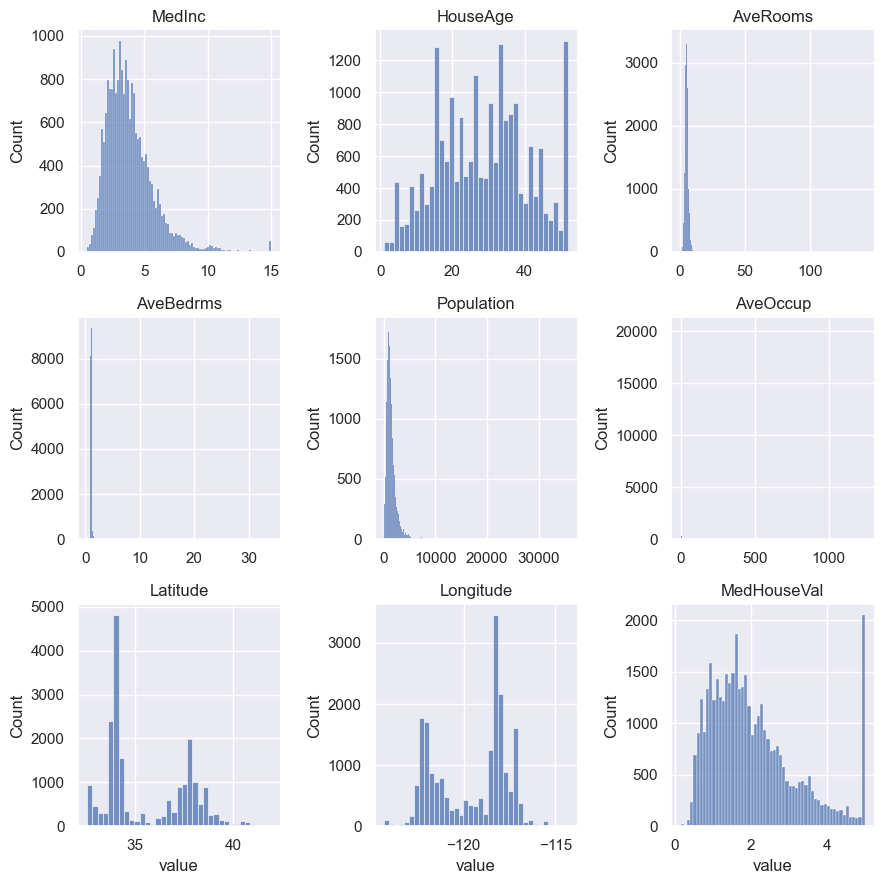

In [447]:
show_hists(df)

In [448]:
features_of_interest = ['AveRooms', 'AveBedrms', 'AveOccup', 'Population']
df[features_of_interest].describe()

,AveRooms,AveBedrms,AveOccup,Population
count,20640.000000,20640.000000,20640.000000,20640.000000
mean,5.429000,1.096675,3.070655,1425.476744
std,2.474173,0.473911,10.386050,1132.462122
min,0.846154,0.333333,0.692308,3.000000
25%,4.440716,1.006079,2.429741,787.000000
50%,5.229129,1.048780,2.818116,1166.000000
75%,6.052381,1.099526,3.282261,1725.000000
max,141.909091,34.066667,1243.333333,35682.000000


## Виводимо розподіл середньої ціни за географічною ознакою

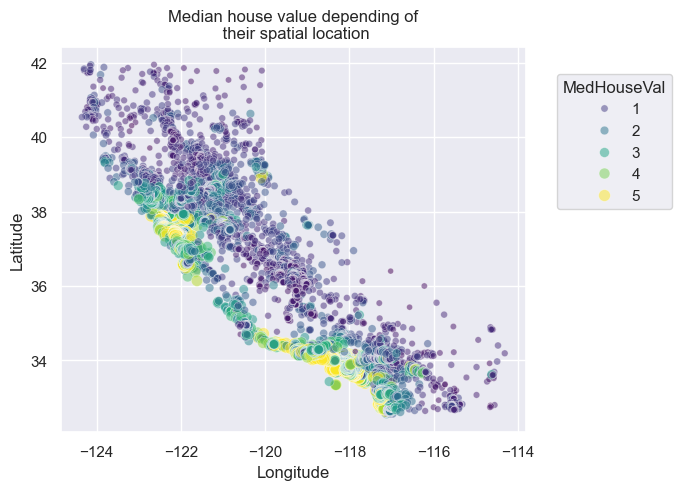

In [449]:
show_geo_corr(df, target)

## Виводимо матрицю кореляцій
Видаляємо колонки, котрі не несуть смислової цінності для кореляцій

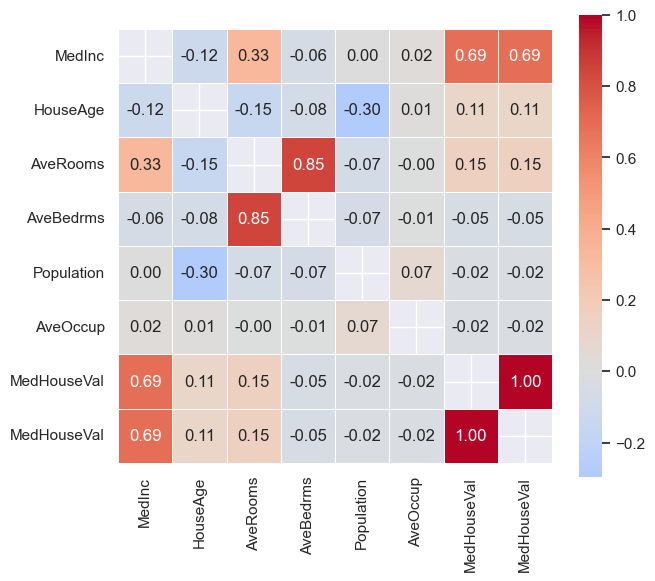

In [450]:
columns_drop = ['Longitude', 'Latitude']
subset = pd.concat([df, target], axis=1).drop(columns=columns_drop)
show_correlation_matrix(subset)

## Досліджуємо обрані колонки на наявність викидів

Згідно з умовою задачі, досліджуємо наступні ознаки:
- AveRooms
- AveBedrms
- AveOccup
- Population

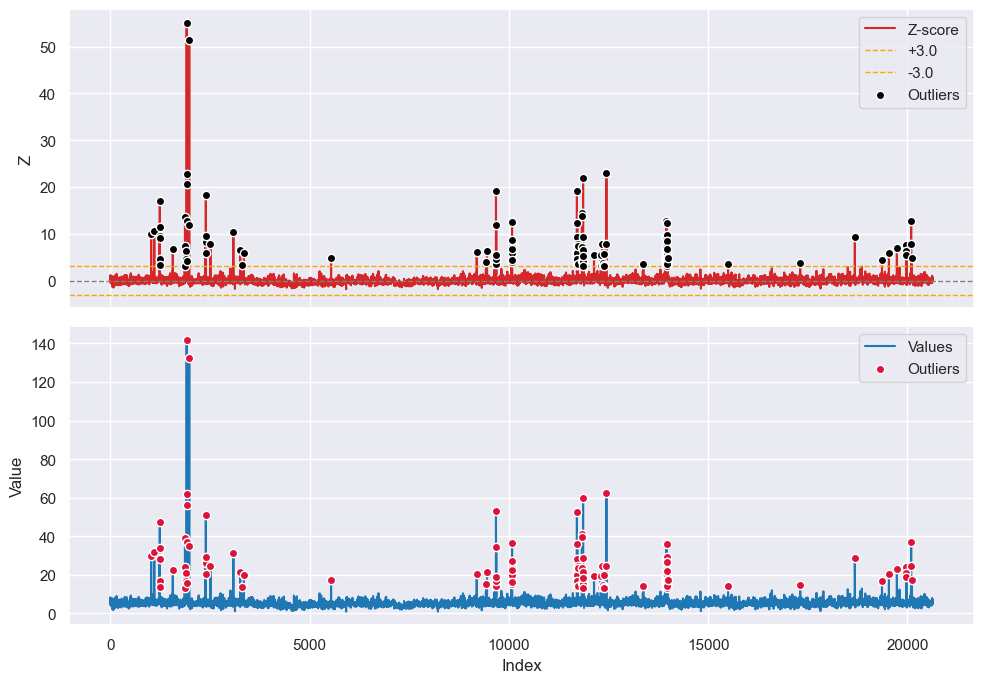

In [451]:
ave_rooms = df['AveRooms']
show_outliers(ave_rooms)

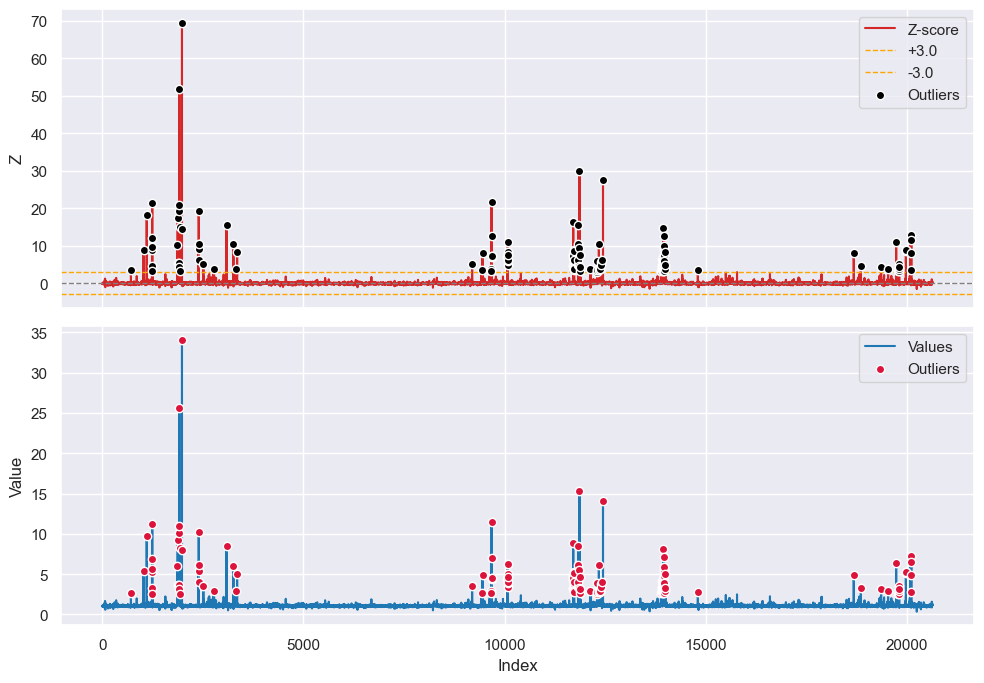

In [452]:
ave_badrooms = df["AveBedrms"]
show_outliers(ave_badrooms)

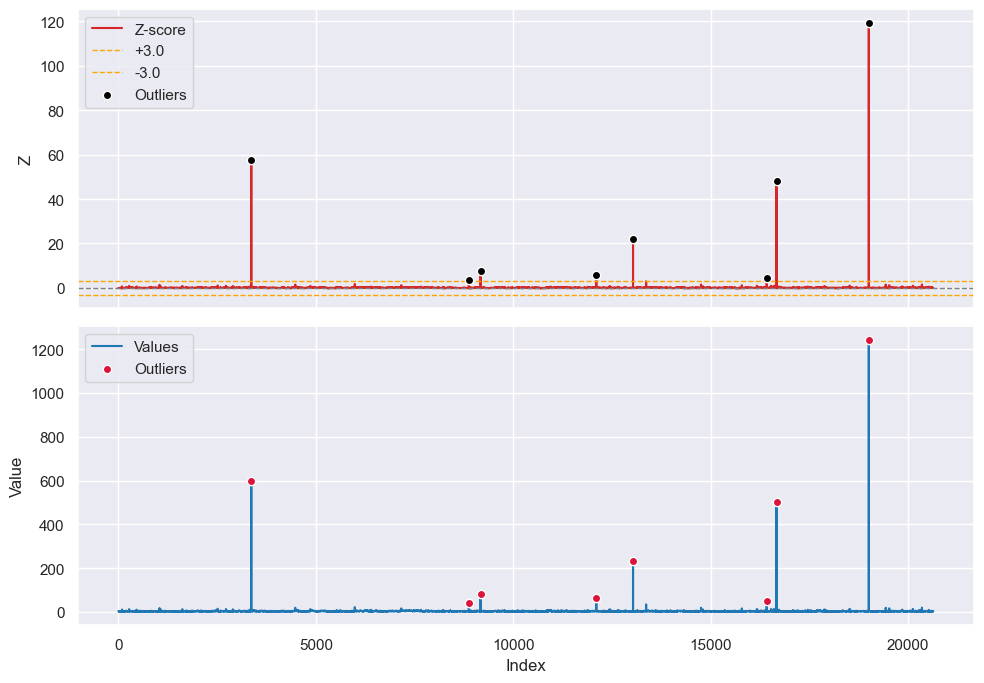

In [453]:
ave_ocup = df["AveOccup"]
show_outliers(ave_ocup)

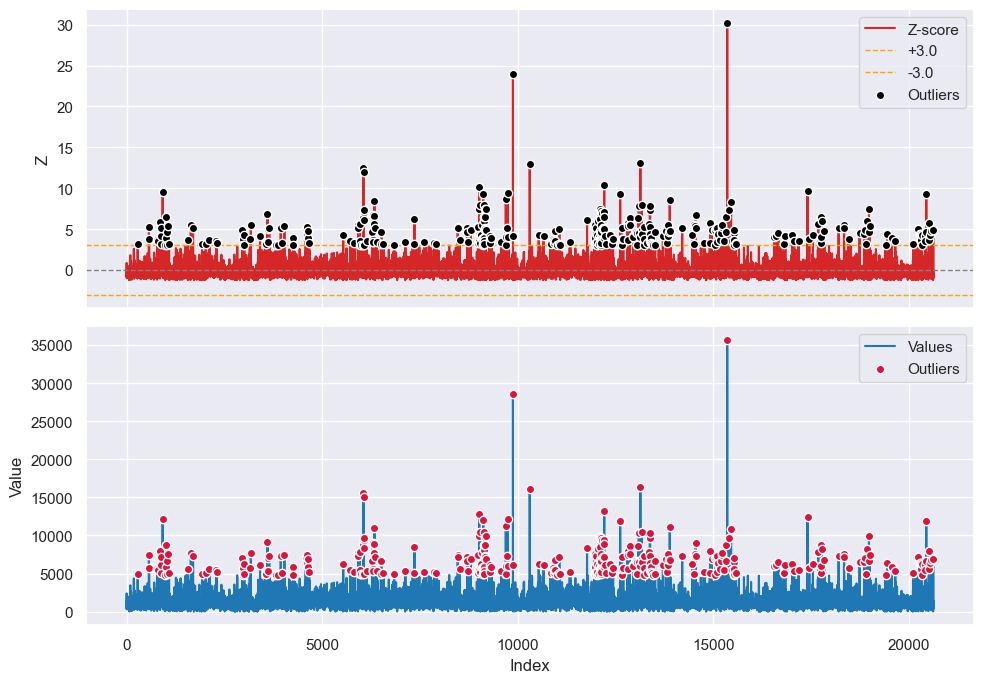

In [454]:
population = df["Population"]
show_outliers(population)

## Видаляємо рядки з викидами в означених ознаках та виводимо оновлену матрицю кореляцій

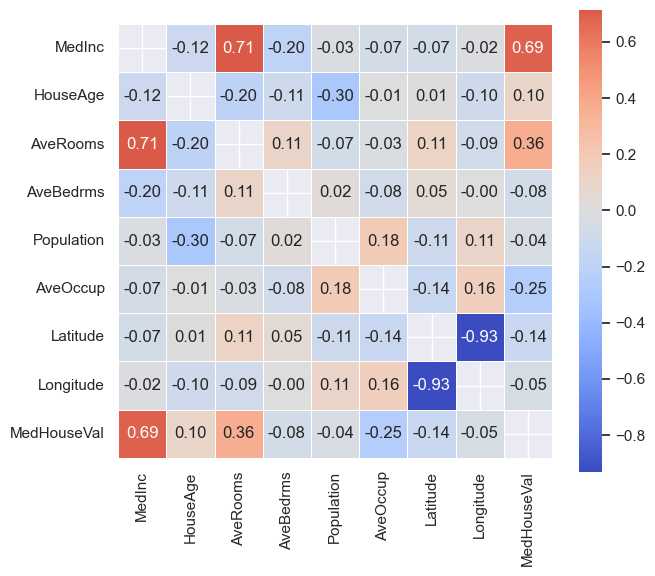

In [455]:
df = remove_outliers(df, 'AveRooms')
df = remove_outliers(df, 'AveBedrms')
df = remove_outliers(df, 'AveOccup')
df = remove_outliers(df, 'Population')
show_correlation_matrix(df)

## Виводимо графіки викидів за заявленими ознаками після видалення викидів

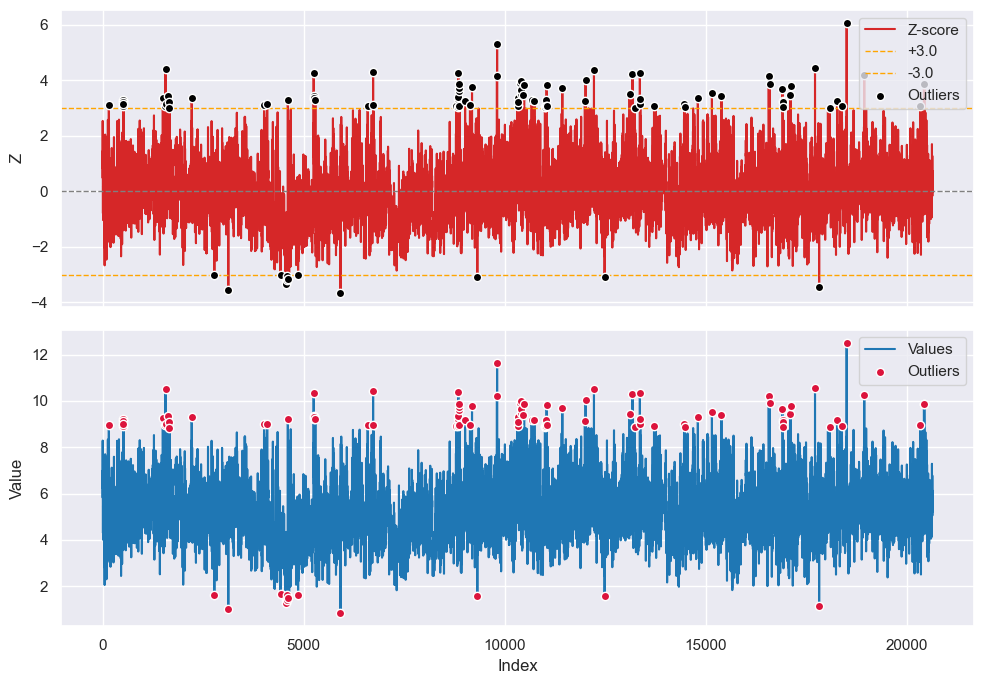

In [456]:
ave_rooms = df['AveRooms']
show_outliers(ave_rooms)

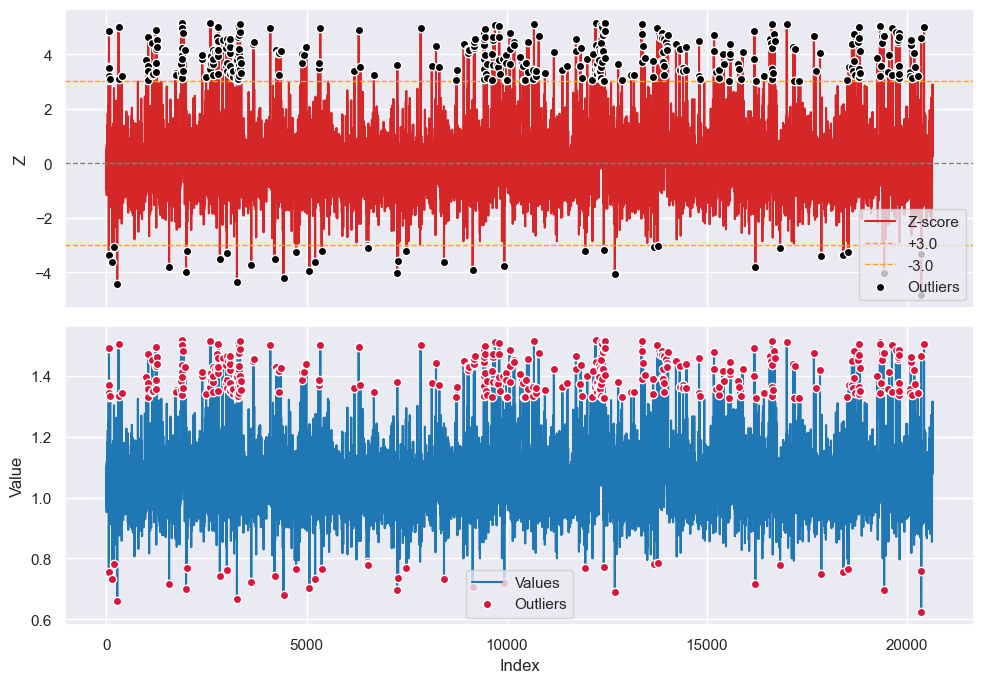

In [457]:
ave_badrooms = df["AveBedrms"]
show_outliers(ave_badrooms)

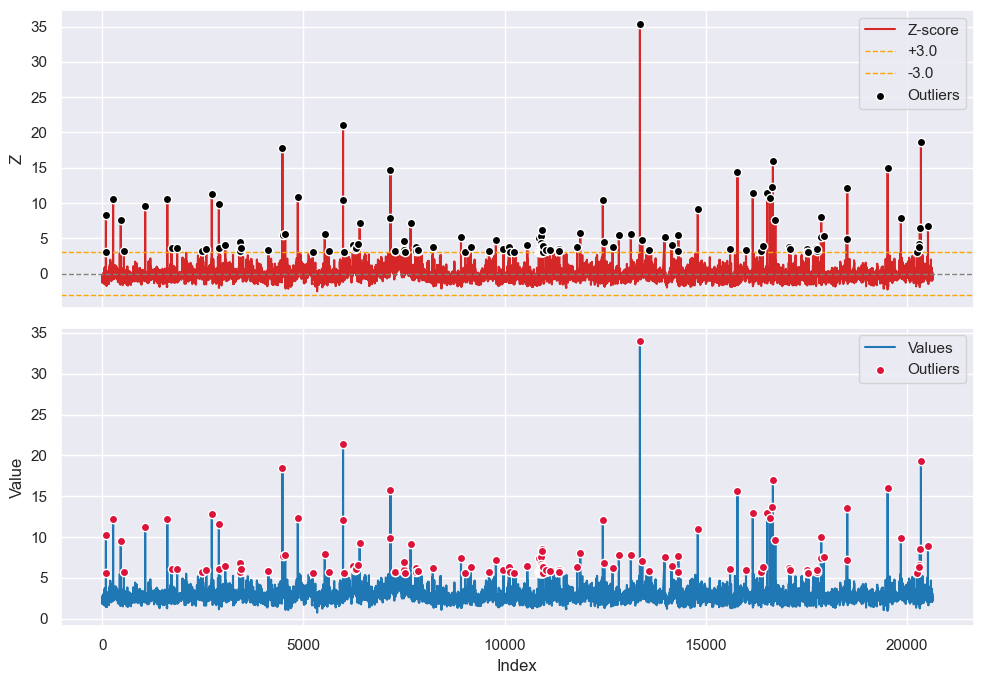

In [458]:
ave_ocup = df["AveOccup"]
show_outliers(ave_ocup)

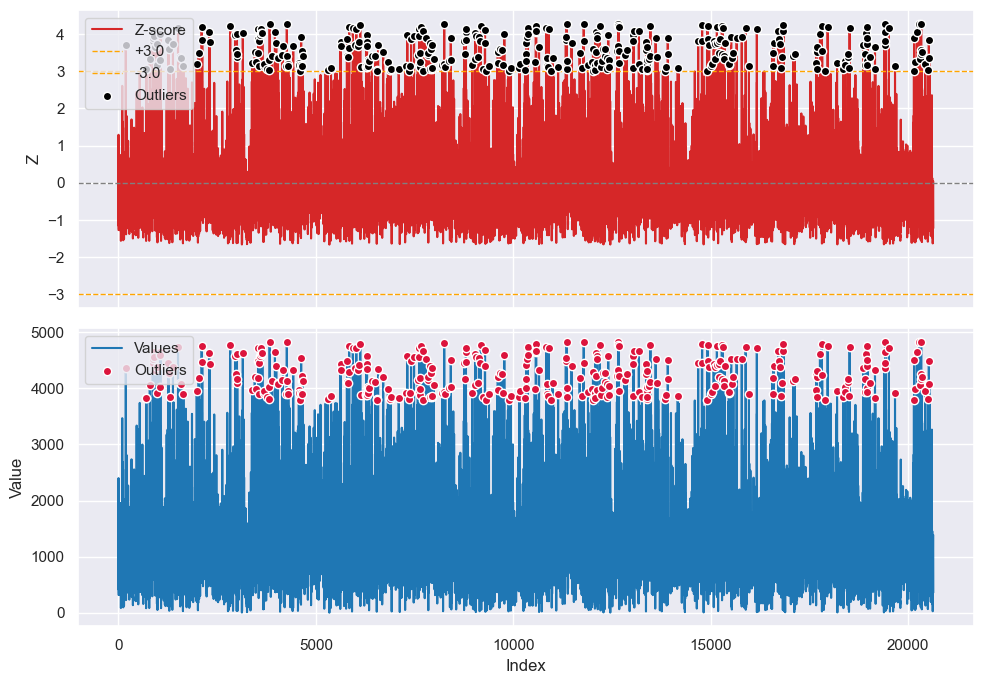

In [459]:
population = df["Population"]
show_outliers(population)

## Розбиваємо очищений датасет на тренувальні та тестові дані

In [460]:
from sklearn.model_selection import train_test_split
X = df.drop(columns='MedHouseVal')
y = df['MedHouseVal']
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

## Будуємо модель для прогнозування
Згідно з поставленою задачею ми стандартизуємо дані через *StandardScaler* та проганяємо через лінійну регресію. Для оптимізації пороцесу реалізуємо це конвеєром.

In [461]:
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

model = Pipeline(steps=[
        ("scaler", StandardScaler()),
        ("clf", LinearRegression())
    ])
model.fit(X_train, y_train)

,steps,"[('scaler', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None


## Оцінюємо якість моделі

In [462]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

y_pred = model.predict(X_test)

r_sq_upd = model.score(X_train, y_train)
mae_upd = mean_absolute_error(y_test, y_pred)
mape_upd = mean_absolute_percentage_error(y_test, y_pred)

print(f'R2: {r_sq_upd:.2f} | MAE: {mae_upd:.2f} | MAPE: {mape_upd:.2f}')

R2: 0.66 | MAE: 0.49 | MAPE: 0.29
